In [1]:
import pandas as pd
import sys

from numpy.f2py.f2py2e import numpy_version
import matplotlib.pyplot as plt
sys.path.append(
    r"C:\Users\TurkmenBersu\PyCharmMiscProject\project_betrokkenheid\notebooks\src"
)
import betrokkenheid
from betrokkenheid.load_data import load_data
from betrokkenheid.analyse import analyse_hoofdeffect, analyse_grouped, maak_effectsamenvatting, bouw_effect_summary, compute_enps_driver_table
from betrokkenheid.heatmaps import plot_hoofdeffect_heatmap, plot_top5_heatmap, plot_hoofdeffect_heatmap_adjusted, plot_corr_highlight
from betrokkenheid.stats import run_regressies_op_vragen, compute_theme_importance, bepaal_belangrijkste_factor_per_thema, compute_driver_table
file_path = r"C:\Users\TurkmenBersu\OneDrive - PostNL\Analyse betrokkenheidsmonitor\ruwedatawbscumq2q3.xlsx"

# Betrokkenheid (gem) keys
four_keys = [
    "Ik heb het gevoel dat ik bij PostNL pas",
    "Mijn werk geeft mij energie",
    "Ik heb plezier in mijn werk",
    "Ik ben trots op PostNL"
]

In [2]:
df, df_genx, df_nonx, questions_full, labels_full = load_data(file_path)

In [3]:
df["Dienstjarengroep_samengevat"].unique()

array(['10-20', '2-5', '20-30', '30-40', '5-10', '<2', 'vanaf 40 jaar'],
      dtype=object)

C:\Users\TurkmenBersu\PyCharmMiscProject\project_betrokkenheid\notebooks\src\betrokkenheid\heatmaps.py:130: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TurkmenBersu\PyCharmMiscProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


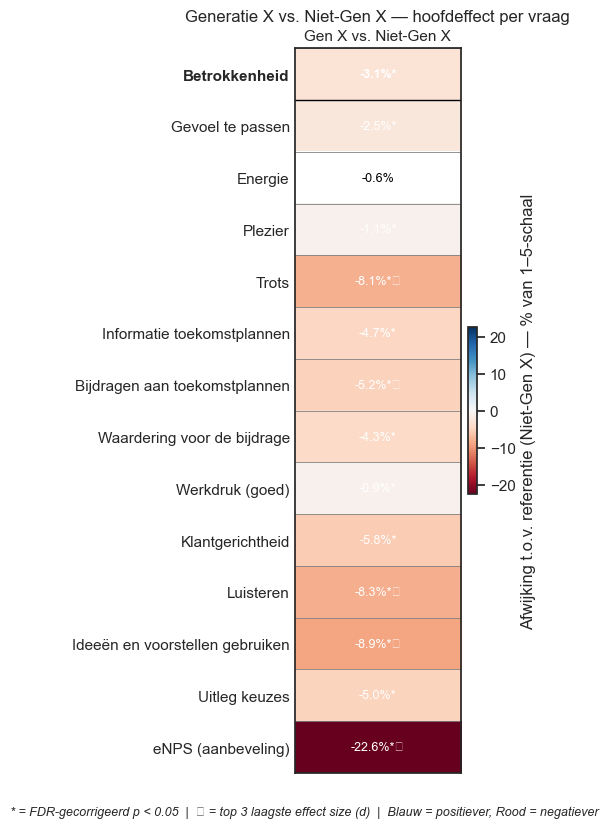

In [4]:
delta_main_pct, sig_main, effect_sizes = analyse_hoofdeffect(df_genx, df_nonx, questions_full)

plot_hoofdeffect_heatmap(
    delta_main_pct=delta_main_pct,
    sig_main=sig_main,
    labels_full=labels_full,
    effect_sizes=effect_sizes,
    topk_effect=5
)

In [6]:
# mappingen
label_map = dict(zip(questions_full, labels_full))      # vraag -> kort label
label_to_question = dict(zip(labels_full, questions_full))  # kort label -> vraag

# jouw top 5 vragen, trots en enps correleren en ideeen en luisteren correleren
top5_questions = [
    "Binnen PostNL worden ideeën en voorstellen van medewerkers gebruikt om te verbeteren",
    "Ik ben trots op PostNL",
    "Binnen PostNL wordt er goed geluisterd naar medewerkers",
    "Ik vind dat mijn werk bijdraagt aan het behalen van de toekomstplannen van PostNL",
    "Hoe waarschijnlijk is het dat je PostNL als werkgever zou aanbevelen bij anderen?"
]

# top 5 labels voor in de plots
top5_labels = [label_map[q] for q in top5_questions]

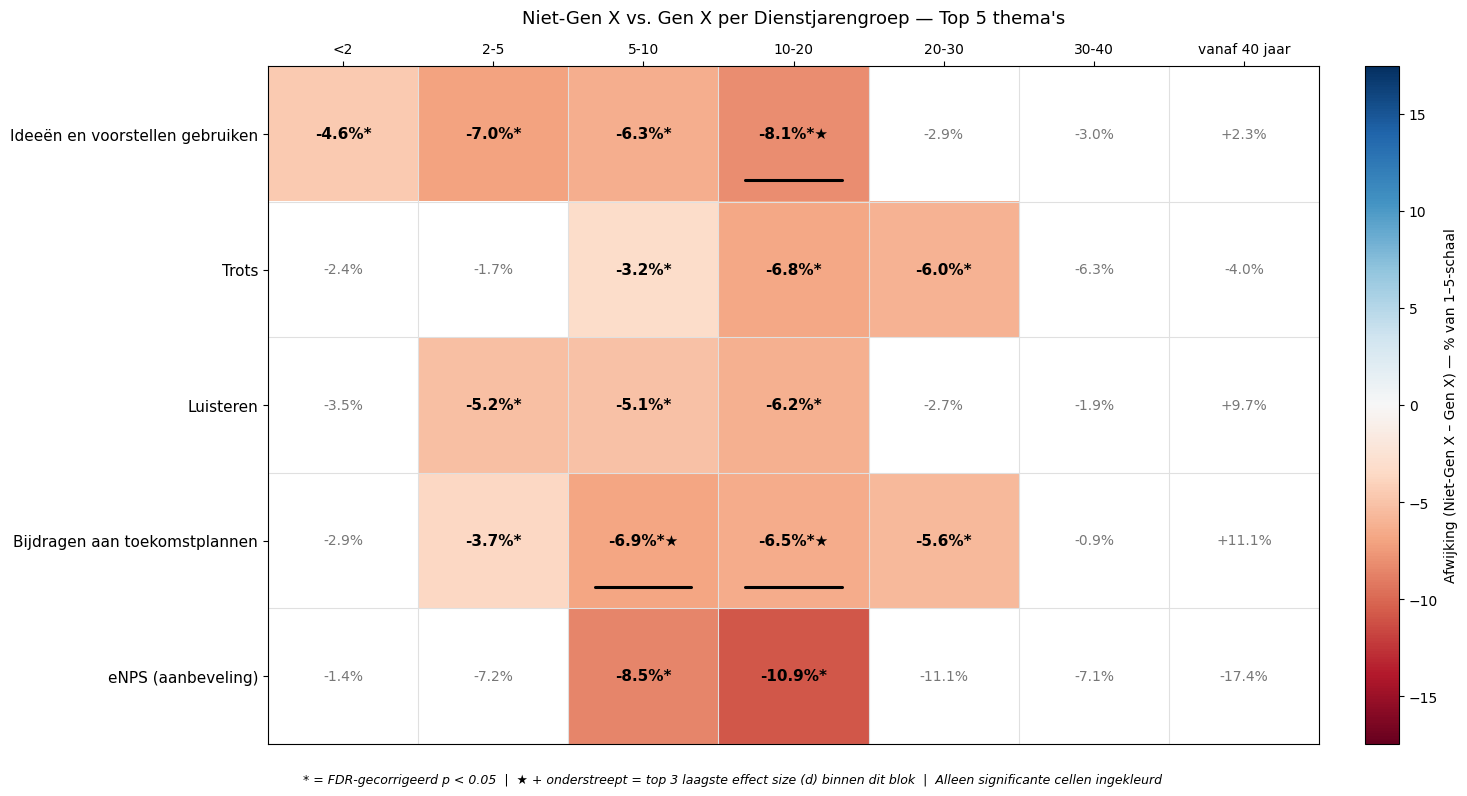

In [7]:
# analyse
delta_dj, sig_dj, groups_dj, d_dj = analyse_grouped(
    df_genx, df_nonx, questions_full,
    group_col="Dienstjarengroep_samengevat",
    group_order=["<2","2-5","5-10","10-20","20-30","30-40", "vanaf 40 jaar"]
)
# plotten
plot_top5_heatmap(
    delta=delta_dj,
    sig=sig_dj,
    top5_labels=top5_labels,
    label_to_question=label_to_question,
    effect_sizes=d_dj,
    topk_effect=3,
    group_label="Dienstjarengroep"
)


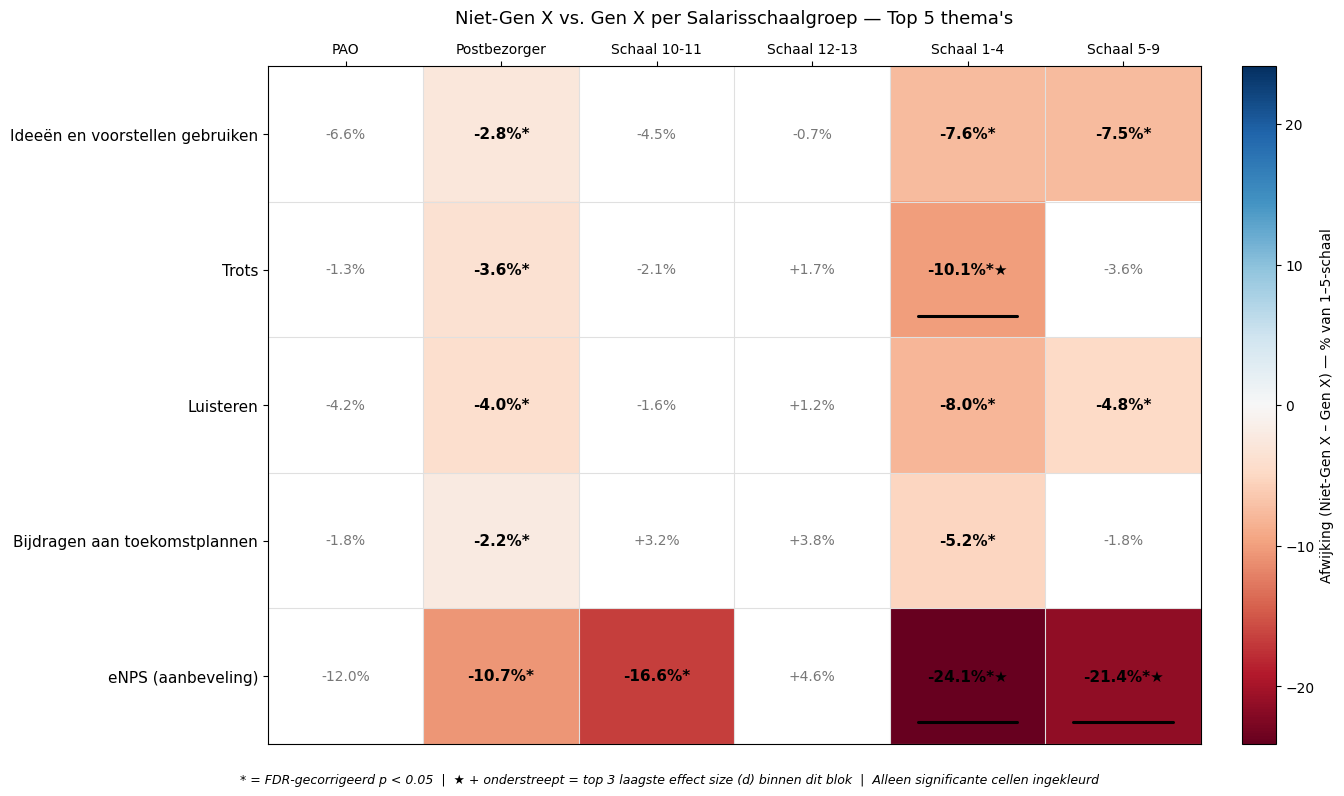

In [8]:
delta_ss, sig_ss, groups_ss, d_ss = analyse_grouped(
    df_genx, df_nonx, questions_full,
    group_col="Salarisschaalgroep",
    group_order=["PAO", "Postbezorger", "Schaal 10-11", "Schaal 12-13", "Schaal 1-4", "Schaal 5-9"]
)

plot_top5_heatmap(
    delta=delta_ss,
    sig=sig_ss,
    top5_labels=top5_labels,
    label_to_question=label_to_question,
    effect_sizes=d_ss,
    topk_effect=3,
    group_label="Salarisschaalgroep"
)


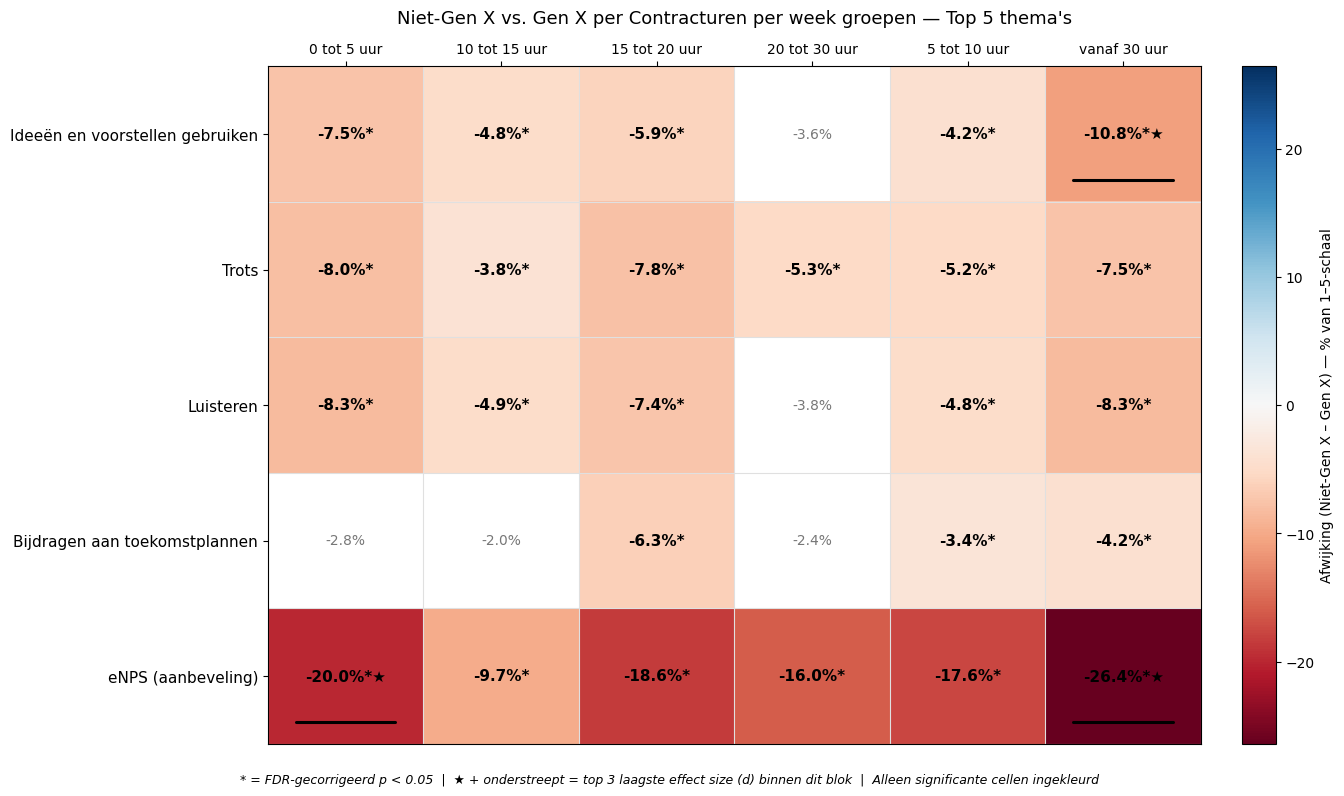

In [9]:
delta_uren, sig_uren, groups_uren, d_uren = analyse_grouped(
    df_genx, df_nonx, questions_full,
    group_col="Contracturen per week groepen",
    group_order=["0 tot 5 uur", "10 tot 15 uur", "15 tot 20 uur", "20 tot 30 uur", "5 tot 10 uur", "vanaf 30 uur"])

plot_top5_heatmap(
    delta=delta_uren,
    sig=sig_uren,
    top5_labels=top5_labels,
    label_to_question=label_to_question,
    effect_sizes=d_uren,
    topk_effect=3,
    group_label="Contracturen per week groepen"
)


In [10]:
# Kolomnaam veranderen
df_genx = df_genx.rename(columns={"Contracturen per week groepen": "Contracturen_per_week_groepen"})
df_nonx = df_nonx.rename(columns={"Contracturen per week groepen": "Contracturen_per_week_groepen"})

In [11]:
# Effect gen x op top 5 themas niet gecontroleerd voor andere variabelen
df_all = pd.concat([df_genx.assign(GenX=1), df_nonx.assign(GenX=0)])
results_before = run_regressies_op_vragen(
    df=df_all,
    questions=top5_questions,
    group_var="GenX",
    covariates=None,
    alpha=0.05
)
eff_pct_before = results_before.set_index("Thema")["Coef_GenX"] * 25
eff_pct_before_top5 = eff_pct_before.loc[top5_questions]

sig_before_top5 = (
    results_before
    .set_index("Thema")
    .loc[top5_questions, "Significant"]
    .to_numpy()
)

In [12]:
results_before

,Thema,Coef_GenX,p_value_GenX,Significant
0,Binnen PostNL worden ideeën en voorstellen van...,-0.356128,2.060742e-43,True
1,Ik ben trots op PostNL,-0.324203,3.361112e-38,True
2,Binnen PostNL wordt er goed geluisterd naar me...,-0.331205,2.981289e-37,True
3,Ik vind dat mijn werk bijdraagt aan het behale...,-0.208134,7.885046e-23,True
4,Hoe waarschijnlijk is het dat je PostNL als we...,-0.903787,1.232311e-47,True


In [13]:
# Gecontroleerd voor andere variabelen
results_after = run_regressies_op_vragen(
    df=df_all,
    questions=top5_questions,
    group_var="GenX",
    covariates= ["Dienstjarengroep_samengevat", "Salarisschaalgroep", "Contracturen_per_week_groepen"],
    alpha=0.05
)

eff_pct_after = results_after.set_index("Thema")["Coef_GenX"] * 25
eff_pct_after_top5 = eff_pct_after.loc[top5_questions]

sig_after_top5 = (
    results_after
    .set_index("Thema")
    .loc[top5_questions, "Significant"]
    .to_numpy()
)

In [14]:
results_after

,Thema,Coef_GenX,p_value_GenX,Significant
0,Binnen PostNL worden ideeën en voorstellen van...,-0.044633,0.113724,False
1,Ik ben trots op PostNL,-0.009080,0.743578,False
2,Binnen PostNL wordt er goed geluisterd naar me...,-0.011813,0.677840,False
3,Ik vind dat mijn werk bijdraagt aan het behale...,-0.023052,0.327435,False
4,Hoe waarschijnlijk is het dat je PostNL als we...,0.044797,0.509138,False


In [15]:
# Berekent voor elk (top 5) thema de effecten van alle variabelen en de groepen
importance_df = compute_theme_importance(df_genx, df_nonx, top5_questions, top_k=None)
importance_df

KeyboardInterrupt: 

In [15]:
# Alleen significante effecten
sig = importance_df[importance_df["Significant"] == True].copy()

# Sorteer per thema op coef (laag → hoog)
sig_sorted = sig.sort_values(["Thema", "Coef"], ascending=[True, True])

# Pak top 3 (laagste coef) per thema
top3_per_thema = (
    sig_sorted
    .groupby("Thema", group_keys=False)
    .head(3)
)

top3_per_thema



,Thema,Variabele,Coef,p-value,Significant
2,Binnen PostNL worden ideeën en voorstellen van...,C(Salarisschaalgroep)[T.Postbezorger],-0.638489,3.099121e-13,True
4,Binnen PostNL worden ideeën en voorstellen van...,C(Salarisschaalgroep)[T.Schaal 1-4],-0.473861,2.558218e-07,True
6,Binnen PostNL worden ideeën en voorstellen van...,C(Contracturen_per_week_groepen)[T.vanaf 30 uur],-0.313283,3.064616e-04,True
42,Binnen PostNL wordt er goed geluisterd naar me...,C(Salarisschaalgroep)[T.Postbezorger],-0.538592,2.507371e-10,True
45,Binnen PostNL wordt er goed geluisterd naar me...,C(Contracturen_per_week_groepen)[T.vanaf 30 uur],-0.409911,1.210930e-06,True
46,Binnen PostNL wordt er goed geluisterd naar me...,C(Contracturen_per_week_groepen)[T.20 tot 30 uur],-0.401626,8.003346e-07,True
85,Hoe waarschijnlijk is het dat je PostNL als we...,C(Salarisschaalgroep)[T.Postbezorger],-0.982163,7.170514e-07,True
86,Hoe waarschijnlijk is het dat je PostNL als we...,C(Salarisschaalgroep)[T.Schaal 1-4],-0.877062,3.260011e-05,True
87,Hoe waarschijnlijk is het dat je PostNL als we...,C(Contracturen_per_week_groepen)[T.vanaf 30 uur],-0.758218,1.234797e-04,True
20,Ik ben trots op PostNL,C(Salarisschaalgroep)[T.Yep],-1.223507,1.827559e-02,True


In [16]:
# Welke variabele is het sterkst per thema (negatieve effecten alleen)
top_factor = bepaal_belangrijkste_factor_per_thema(importance_df)
top_factor

,Thema,Basisvariabele,MaxNegCoef,AnySignificant
0,Binnen PostNL worden ideeën en voorstellen van...,Salarisschaalgroep,-0.638489,True
1,Binnen PostNL wordt er goed geluisterd naar me...,Salarisschaalgroep,-0.538592,True
2,Hoe waarschijnlijk is het dat je PostNL als we...,Salarisschaalgroep,-0.982163,True
3,Ik ben trots op PostNL,Salarisschaalgroep,-1.223507,True
4,Ik vind dat mijn werk bijdraagt aan het behale...,Salarisschaalgroep,-0.643186,True


In [17]:
# Welke thema's zijn grootste drivers vvan bertokkenheid (als thema omhoog gaat, gaat coef omhoog)
df_all = pd.concat([df_genx.assign(GenX=1), df_nonx.assign(GenX=0)])

driver_table = compute_driver_table(df_all, questions_full, four_keys)
driver_table

,Predictor,Coef,AbsCoef,p-value,Significant
2,Q('Ik voel mij gewaardeerd voor de bijdrage di...,0.180066,0.180066,1.398100e-87,True
1,Q('Ik vind dat mijn werk bijdraagt aan het beh...,0.134847,0.134847,5.899416e-41,True
4,Q('Binnen PostNL staat wat belangrijk is voor ...,0.114498,0.114498,1.843215e-43,True
8,Q('Hoe waarschijnlijk is het dat je PostNL als...,0.099762,0.099762,2.890792e-146,True
3,Q('Ik vind mijn werkdruk'),0.073154,0.073154,3.406437e-10,True
5,Q('Binnen PostNL wordt er goed geluisterd naar...,0.027125,0.027125,1.470365e-02,True
7,Q('Er wordt mij goed uitgelegd waarom er bepaa...,0.022338,0.022338,2.551232e-02,True
6,Q('Binnen PostNL worden ideeën en voorstellen ...,-0.021931,0.021931,5.668450e-02,False
0,Q('Ik word voldoende geïnformeerd over de toek...,-0.004759,0.004759,6.807796e-01,False


In [18]:
# Welke thema's zijn grootste drivers van eNPS (als thema omhoog gaat, gaat coef omhoog)
df_all = pd.concat([df_genx.assign(GenX=1), df_nonx.assign(GenX=0)])

driver_eNPS = compute_enps_driver_table(df_all, questions_full, labels_full)
driver_eNPS.head(5)

,Vraag,Thema (kort),Coef,AbsCoef,p-value,Significant
0,Ik ben trots op PostNL,Trots,0.819163,0.819163,5.429824e-120,True
1,Binnen PostNL worden ideeën en voorstellen van...,Ideeën en voorstellen gebruiken,0.335911,0.335911,6.158296e-17,True
2,Ik heb het gevoel dat ik bij PostNL pas,Gevoel te passen,0.328197,0.328197,9.326738e-15,True
3,Ik vind mijn werkdruk,Werkdruk (goed),0.291161,0.291161,1.539219e-12,True
4,Binnen PostNL staat wat belangrijk is voor onz...,Klantgerichtheid,0.215875,0.215875,4.952013e-13,True


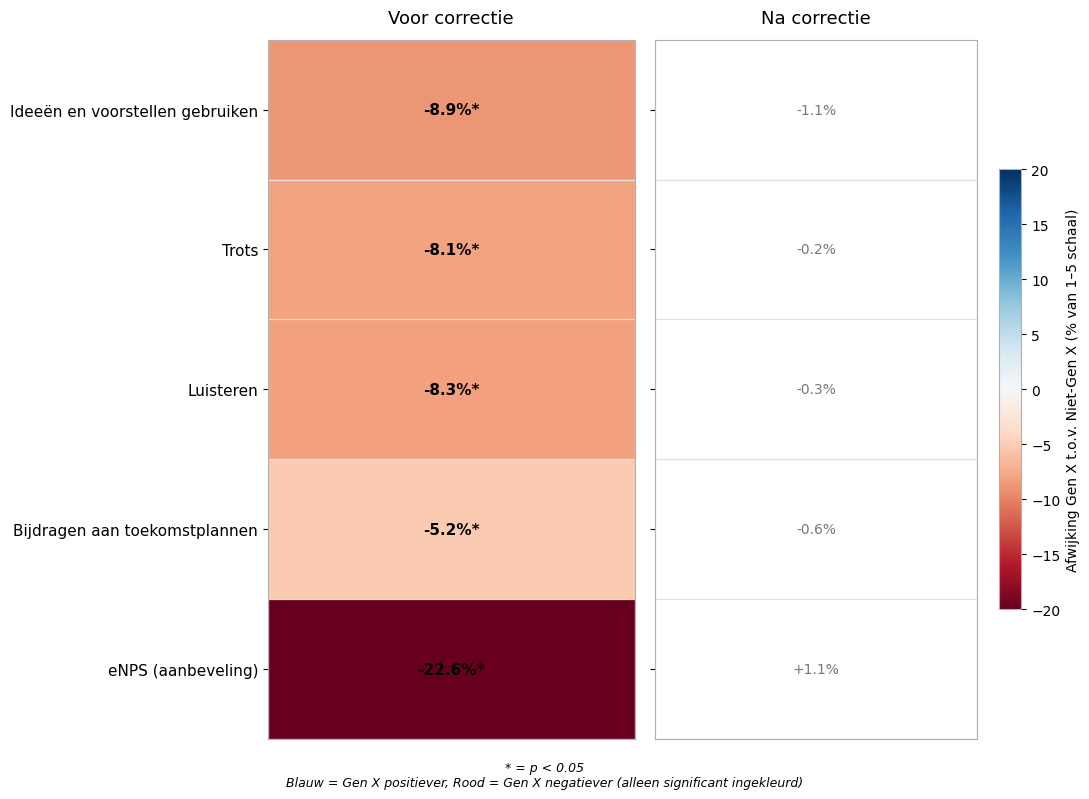

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 8), sharey=True)
fig.patch.set_facecolor("white")

plot_hoofdeffect_heatmap_adjusted(
    eff_pct_before_top5,
    sig_before_top5,
    top5_labels,
    title="Voor correctie",
    ax=axes[0],
    show_colorbar=False,
    add_footnote=False
)

plot_hoofdeffect_heatmap_adjusted(
    eff_pct_after_top5,
    sig_after_top5,
    top5_labels,
    title="Na correctie",
    ax=axes[1],
    show_colorbar=True,
    add_footnote=True
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


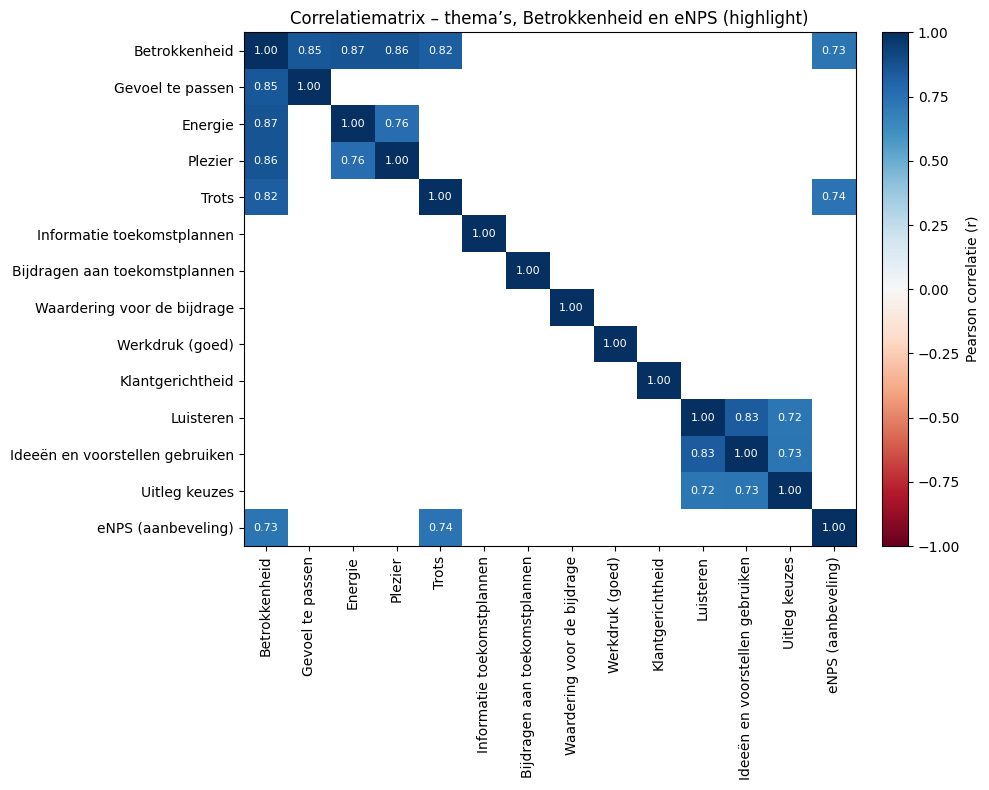

In [20]:
theme_cols = questions_full  # of welke set jij wil
corr_all = plot_corr_highlight(
    df=df_all,
    cols=theme_cols,
    label_map=label_map,  # dict(zip(questions_full, labels_full))
    thr=0.7,
    method="pearson",
    title="Correlatiematrix – thema’s, Betrokkenheid en eNPS (highlight)"
)


In [21]:
import pandas as pd

group_col="Dienstjarengroep_samengevat"
group_order=["<2","2-5","5-10","10-20","20-30","30-40", "vanaf 40 jaar"]

tmp = pd.concat([
    df_genx.assign(is_genx=True),
    df_nonx.assign(is_genx=False)
], ignore_index=True)

seg_table = (
    tmp.groupby(group_col)
       .agg(n_totaal=(group_col, "size"),
            n_genx=("is_genx", "sum"))
       .assign(pct_genx=lambda d: d["n_genx"] / d["n_totaal"])
       .reset_index()
)

overall = tmp["is_genx"].mean()

# volgorde zoals in je plot
seg_table[group_col] = pd.Categorical(seg_table[group_col], categories=group_order, ordered=True)
seg_table = seg_table.sort_values(group_col)

print("Overall % Gen X:", round(overall * 100, 1), "%")
display(seg_table.assign(pct_genx=(seg_table["pct_genx"]*100).round(1)))


Overall % Gen X: 39.6 %


,Dienstjarengroep_samengevat,n_totaal,n_genx,pct_genx
5,<2,4880,617,12.6
1,2-5,3713,858,23.1
4,5-10,4602,1749,38.0
0,10-20,3935,2180,55.4
2,20-30,1857,1097,59.1
3,30-40,1007,835,82.9
6,vanaf 40 jaar,1070,1006,94.0


In [25]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_normality(series, label):
    series = series.dropna()

    stat, p = stats.shapiro(series)
    print(f"{label} — Shapiro-Wilk p-value: {p:.4f}")

    # Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(series, bins=30, edgecolor="black")
    plt.title(f"Histogram — {label}")
    plt.show()

    # QQ-plot
    stats.probplot(series, dist="norm", plot=plt)
    plt.title(f"QQ-plot — {label}")
    plt.show()

In [28]:
outcomes = top5_questions